In [54]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [55]:
train_data = torchvision.datasets.MNIST(root='../data',train = True, download= True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root='../data', train = False, download= True, transform=torchvision.transforms.ToTensor())

In [56]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [57]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()

Corresponding Label is 5


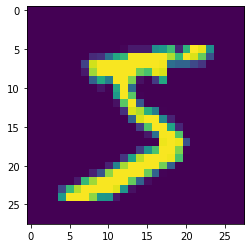

In [58]:
plt.imshow(np.array(np.transpose(train_data[0][0],(1,2,0))))
print(f'Corresponding Label is {train_data[0][1]}')

In [70]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle = True)
testloader  = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle = False)

In [71]:
for images, labels in trainloader:
    break

torch.Size([3, 32, 302])
corresponding labels are [9, 3, 9, 4, 2, 3, 0, 2, 7, 9]


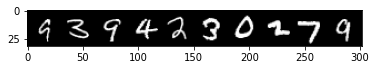

In [72]:
im=torchvision.utils.make_grid(images[:12],nrow=12)
print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))
print(f'corresponding labels are {list(labels.numpy()[:12])}')

In [73]:
class ConvolutionalNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=torch.nn.Conv2d(1,6,3,1)
        self.conv2=torch.nn.Conv2d(6,16,3,1)
        self.fc1=torch.nn.Linear(16*5*5,120)
        self.fc2=torch.nn.Linear(120,84)
        self.fc3=torch.nn.Linear(84,10)
    def forward(self,x):
        x=torch.nn.functional.relu(self.conv1(x))
        x=torch.nn.functional.max_pool2d(x,2,2)
        x=torch.nn.functional.relu(self.conv2(x))
        x=torch.nn.functional.max_pool2d(x,2,2)
        x=torch.nn.functional.relu(self.fc1(x.view(-1,16*5*5)))
        x=torch.nn.functional.relu(self.fc2(x))
        x=self.fc3(x)
        return torch.nn.functional.log_softmax(x,dim=1)

In [74]:
model=ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [75]:
num_param=0
for param in model.parameters():
    num_param+=param.numel()
num_param

60074

In [76]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [77]:
import time
start_time=time.time()

#Trackers
epochs=5
train_loss=[]
test_loss=[]
train_correct=[]
test_correct=[]

#For loop Epochs
for i in range (epochs):
    train_corr=0
    test_corr=0
    
   #TRAIN
    for b, (x_train,y_train) in enumerate(trainloader):
        b+=1
        y_pred=model(x_train)
        loss=criterion(y_pred,y_train)
        predicted=torch.max(y_pred.data,1)[1]
        batch_corr = (predicted==y_train).sum()
        train_corr+=batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%6000==0:
            print(f"Epoch: {i+1}, Batch: {b}, Train Loss: {loss.item()}")
    train_loss.append(loss.item())
    train_correct.append(train_corr)
    
    
    
    #TEST
    with torch.no_grad():
        for b, (x_test,y_test) in enumerate(testloader):
            y_pred=model(x_test)
            loss=criterion(y_pred,y_test)
            predicted=torch.max(y_pred.data,1)[1]
            batch_corr = (predicted==y_test).sum()
            test_corr+=batch_corr
        test_correct.append(test_corr)
        test_loss.append(loss.item())

stop_time=time.time()
total_time=stop_time-start_time

print(f"Total Duration of training is {total_time/60} minutes")

Epoch: 1, Batch: 6000, Train Loss: 0.403707355260849
Epoch: 2, Batch: 6000, Train Loss: 0.004983675200492144
Epoch: 3, Batch: 6000, Train Loss: 0.005308766849339008
Epoch: 4, Batch: 6000, Train Loss: 1.3548837900161743
Epoch: 5, Batch: 6000, Train Loss: 9.075264824787155e-05
Total Duration of training is 6.840349372227987 minutes


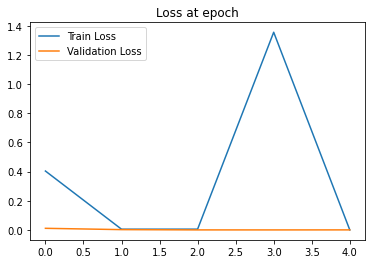

In [78]:
plt.plot(np.array(train_loss),label="Train Loss")
plt.plot(test_loss,label="Validation Loss")
plt.title("Loss at epoch")
plt.legend()
plt.show()

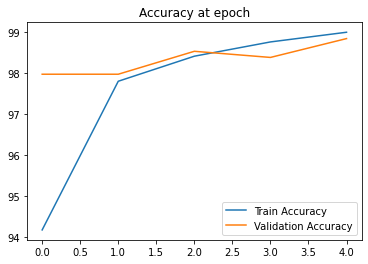

In [80]:
plt.plot([i/600 for i in train_correct],label="Train Accuracy")
plt.plot([i/100 for i in test_correct],label="Validation Accuracy")
plt.title("Accuracy at epoch")
plt.legend()
plt.show()

In [81]:
test_load_all=torch.utils.data.DataLoader(test_data,batch_size=10000,shuffle=False)

In [83]:
with torch.no_grad():
    tst_corr=0
    for b, (x_testall,y_testall) in enumerate(test_load_all):
        b+=1
        y_pred=model(x_testall)
        predicted=torch.max(y_pred.data,1)[1]
        tst_corr+=(predicted==y_testall).sum()   

In [88]:
print(f"Test accuracy is {tst_corr.data*100/len(test_data)} %")

Test accuracy is 98.8499984741211 %
